* Comparing the stop criterion of precision is the goal with the enhanced version
* Describing the risk version

# Setup

In [1]:
# IPython extension to reload modules before executing user code.
# useful to see immediate results in notebook when modifying imported scripts
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from scipy.stats import beta

from utils_stats import (
    #hdi_ci_limits,
    successes_failures_to_hdi_ci_limits
)

from utils_viz import (
    #plot_success_rates
    plot_vhlines_lines,
    plot_parity_line,
    plot_multiple_decision_rates_jammed,
    plot_multiple_decision_rates_separate,
    scatter_stop_iter_sample_rate,
    viz_one_sample_results,
    plot_sample_pdf_methods,
)

from utils_experiments import (
    BinaryAccounting,
    BinomialSimulation,
    BinomialHypothesis,
    stop_decision_multiple_experiments_multiple_methods,
    stats_dict_to_df,
    iteration_counts_to_df,
    sample_all_iterations_results,
)
    

seed = 7

In [3]:

import matplotlib.pyplot as plt
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

FIG_WIDTH, FIG_HEIGHT = 8, 6

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = FIG_WIDTH, FIG_HEIGHT
# plt.rcParams["hatch.linewidth"] = 0.2

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [75]:
from statsmodels.stats.power import NormalIndPower

effect_size = 0.55 - 0.5
alpha = 0.05
power = 0.8

# Use the actual effect size as Cohen's h for proportions
from statsmodels.stats.proportion import proportion_effectsize
h = proportion_effectsize(0.5, 0.55)

analysis = NormalIndPower()
n = analysis.solve_power(effect_size=h, alpha=alpha, power=power, alternative='two-sided')
print(f"Sample size needed: {n:.0f}")

Sample size needed: 1565


# Data

Experiments each containing many Bernoulli trials

# Experiments

In [4]:
hypothesis_0pt5 = BinomialHypothesis()

0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


In [5]:
binary_accounting = BinaryAccounting()

## Fair Coin

In [6]:
synth_0pt5 = BinomialSimulation(n_experiments=2000)

Generating synthetic data with parameter values:
0.5: true success rate
2000: experiments
1500: sample size per experiment


In [7]:
hypothesis_0pt5.run_hypothesis_on_experiments(synth_0pt5.experiments, binary_accounting)

Sample 11 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 799, 'failures': 701, 'hdi_min': 0.5074142760260834, 'hdi_max': 0.5578881163957048, 'precision_goal_achieved': True}
Sample 61 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 804, 'failures': 696, 'hdi_min': 0.5107636035522547, 'hdi_max': 0.5612141943766372, 'precision_goal_achieved': True}
Sample 64 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 790, 'failures': 710, 'hdi_min': 0.5014038032397002, 'hdi_max': 0.551913781126643, 'precision_goal_achieved': True}
Sample 65 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False

,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.9210,0.061,0.9820,0.0180,592.9835,290.737790,0.498253,0.051782
pitg,0.3670,0.000,0.3670,0.6330,598.2090,1.457526,0.499978,0.020554
epitg,0.9765,0.000,0.9765,0.0235,740.9665,221.187573,0.500032,0.013120


In [8]:
hypothesis_0pt5.method_df_stats['pitg']['success_rate'].mean(), hypothesis_0pt5.method_df_stats['pitg'].query("accept")['success_rate'].mean()


(0.49997758401944337, 0.5002934045389008)

In [9]:
hypothesis_0pt5.method_df_stats['pitg']['success_rate'].mean(), hypothesis_0pt5.method_df_stats['pitg'].query("conclusive")['success_rate'].mean(), hypothesis_0pt5.method_df_stats['pitg'].query("inconclusive")['success_rate'].mean()

(0.49997758401944337, 0.5002934045389008, 0.49979447796787874)

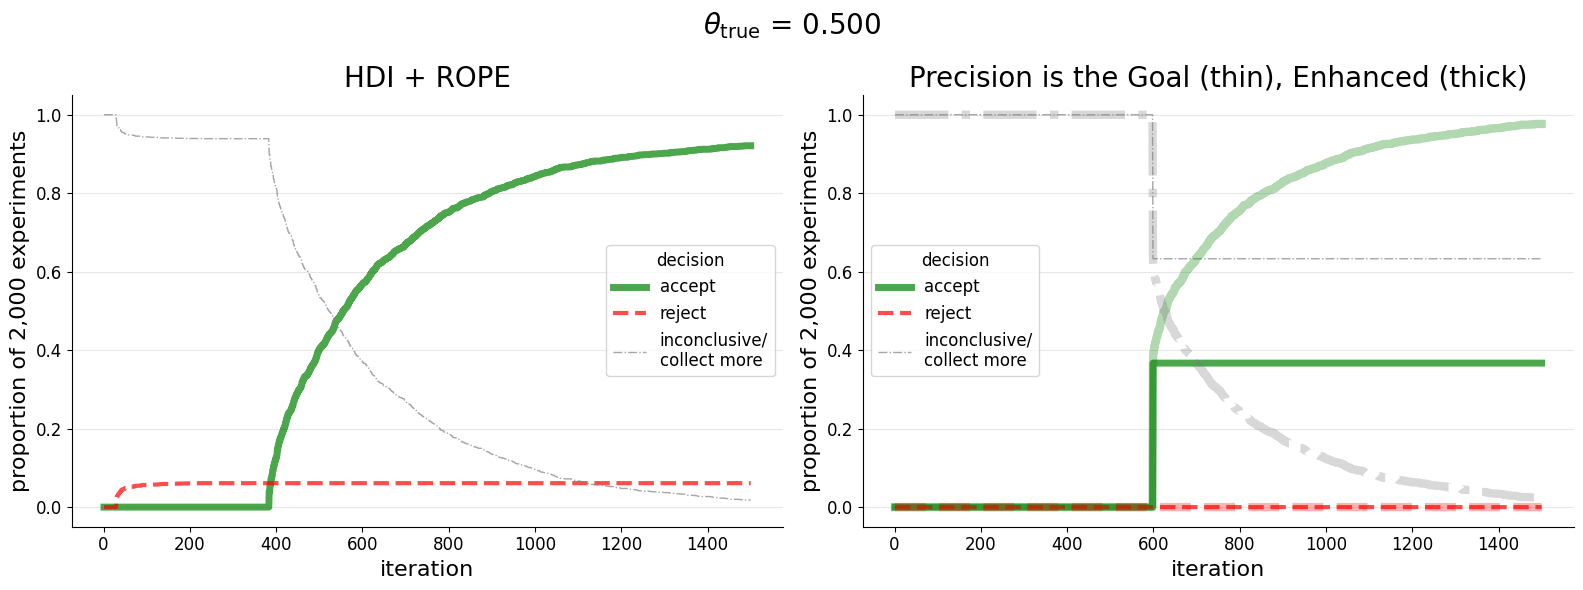

In [66]:
hypothesis_0pt5.plot_decision_rates(synth_0pt5.success_rate)

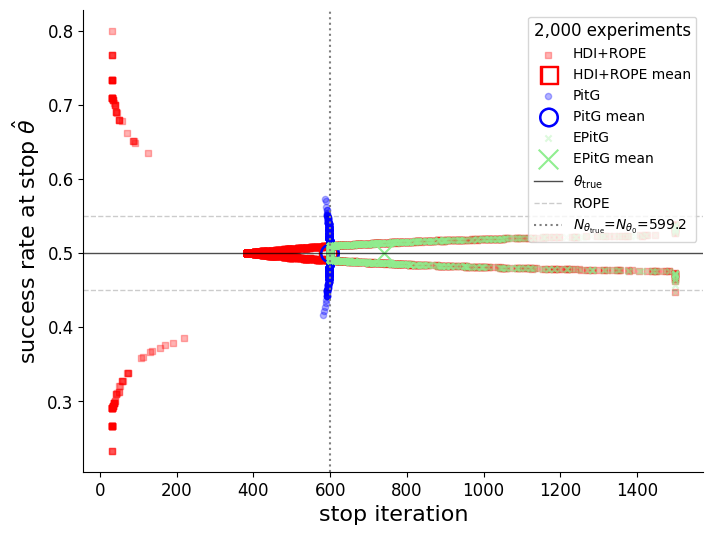

In [65]:
hypothesis_0pt5.plot_stop_iter_sample_rates(success_rate=synth_0pt5.success_rate, title=None)

In [12]:
# experiment ids for which:
# - HDI_ROPE method had success rate > 0.55
# - PITG method was inconclusive
# - EPITG method was conclusive

experiment_idxs = list(sorted(set(hypothesis_0pt5.method_df_stats["pitg"].query("inconclusive").index) &\
set(hypothesis_0pt5.method_df_stats["epitg"].query("accept").index) &\
set(hypothesis_0pt5.method_df_stats["hdi_rope"].query("success_rate > 0.55").index)))
len(experiment_idxs)

35

1011010001100100001011111111100101011011100011111100101001101111111101110011110011100111100010100010111101011111100011111111111000001010010011000000011010001000100000000100101110011101001110000100101100110100001010111100111111110111001010110111001001010100111101010011110111001011100100110010100100010010110101010101001111001100110110111011100101000101100110011001011110011111011101010100011011101111000101101010101010101111000010001110110010101011001001100100011011011111001110000100110010000010101100101011010000011001010001101011100101011010001001101001001001101101001010111000011010001111110010011111001000111000110001010010101011100100001101111011110111001110110100100010010011110111001000001000111000000100101111110111101010001101100100011001010111100000010011011111000000010100110010011100010101000001011111001011100110110101110010000111100100111111100111111111001110110100001011101100011001110010000100111011001110001100101000000011011100001100111001110111001010011010100110010101000110000000

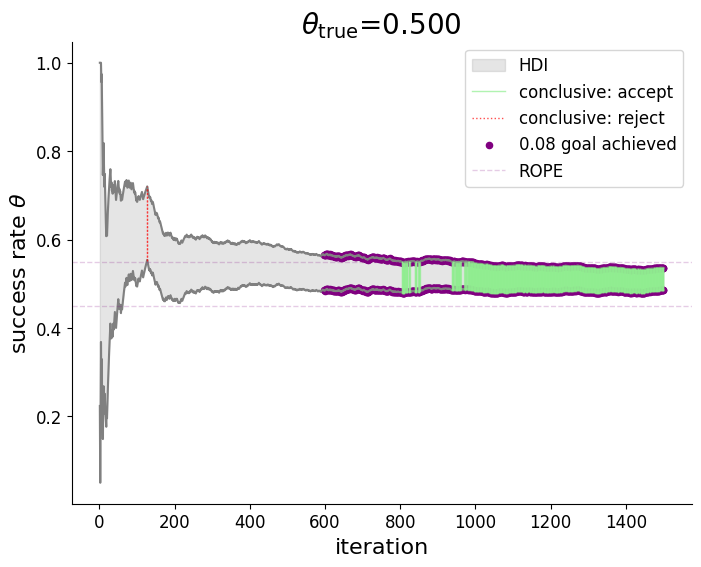

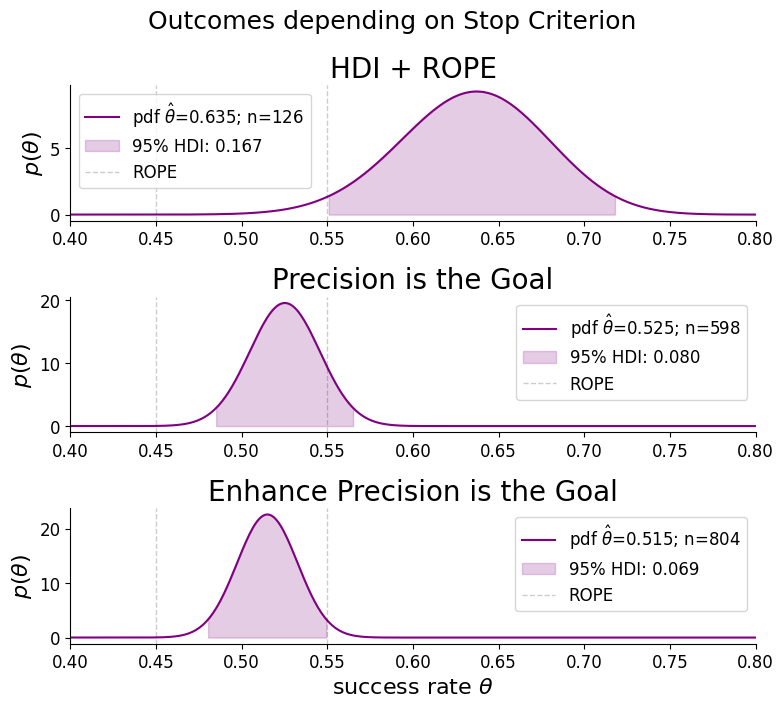

In [64]:
# Visualising outcomes of one experiment

#iexperiment = experiment_idxs[1]  # good example
iexperiment = experiment_idxs[2]  # good example

# for viz
method_names = ["hdi_rope", "pitg", "epitg"]

print("".join([f"{b_}" for b_ in hypothesis_0pt5.experiments[iexperiment,:] ]))

xlim = (0.4, 0.8)
df_experiment_results = hypothesis_0pt5.one_experiment_all_iterations(iexperiment, binary_accounting=binary_accounting, viz=True, success_rate=synth_0pt5.success_rate, method_names=method_names, xlim=xlim)

plt.savefig('../latex/foo.png')

In [27]:
# Bayes Factor, by ChatGPT: https://chatgpt.com/c/687359bf-a0b0-8003-b5a4-3f5c89fa7d63

from scipy.stats import binom
from scipy.special import beta as beta_special
print(hypothesis_0pt5.experiments[iexperiment,:])

k = hypothesis_0pt5.experiments[iexperiment,:126].sum()
n = hypothesis_0pt5.experiments[iexperiment,:126].shape[0]

print(n, k, k/n)

# H0: Fair coin (theta = 0.5)
p_H0 = binom.pmf(k, n, 0.5)

# H1: Uniform prior on theta => beta-binomial marginal likelihood
# P(D | H1) = B(k+1, n-k+1) / B(1,1)
p_H1 = beta_special(k + 1, n - k + 1) / beta_special(1, 1)

# Bayes Factor
BF_10 = p_H1 / p_H0

p_H0, p_H1, BF_10

[1 0 1 ... 1 1 0]
126 80 0.6349206349206349


(0.0007080591411767416, 1.3072158089385334e-37, 1.8461957948400159e-34)

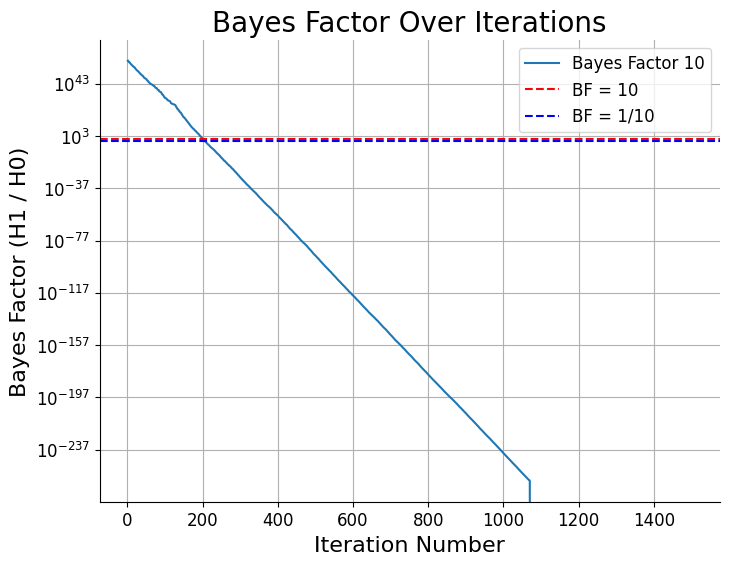

In [54]:
a_prior = 100  # Uniform prior
b_prior = 100  # Uniform prior
p_null = 0.5  # Null hypothesis probability

sequence = hypothesis_0pt5.experiments[iexperiment,:].copy()

iteration_number = np.arange(1, len(sequence) + 1)
iteration_successes = sequence.cumsum()
iteration_failures = iteration_number - iteration_successes

p_H0s = binom.pmf(iteration_successes, iteration_number, p_null)
p_H1s = beta_special(iteration_successes + 1, iteration_failures + 1) / beta_special(a_prior, b_prior)

BF_10s = p_H1s / p_H0s


plt.plot(iteration_number, BF_10s, label='Bayes Factor 10')
plt.yscale('log')

plt.axhline(10, color='red', linestyle='--', label='BF = 10')
plt.axhline(1/10, color='blue', linestyle='--', label='BF = 1/10')
plt.xlabel('Iteration Number')
plt.ylabel('Bayes Factor (H1 / H0)')
plt.title('Bayes Factor Over Iterations')
plt.legend()
plt.grid(True)
#plt.ylim(1./1000, 1000)

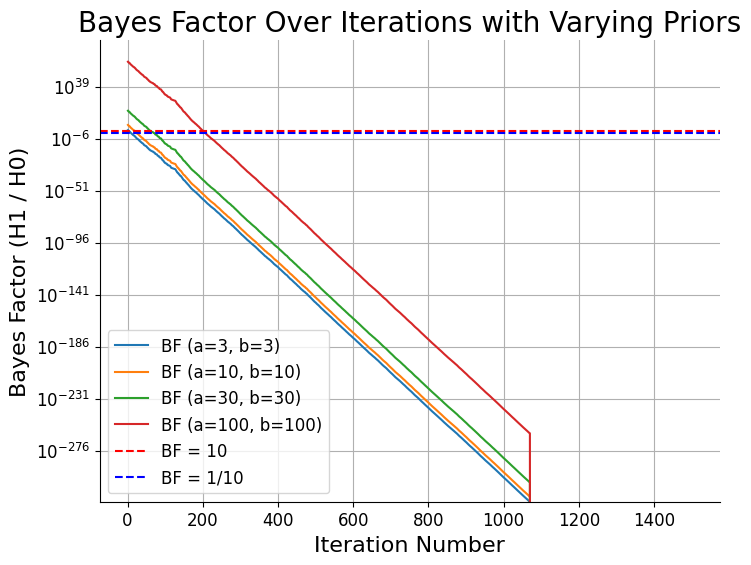

In [63]:
a_priors = [3, 10, 30, 100]
b_priors = [3, 10, 30, 100]

for a_prior, b_prior in zip(a_priors, b_priors):
    p_H1s = beta_special(iteration_successes + 1, iteration_failures + 1) / beta_special(a_prior, b_prior)
    BF_10s = p_H1s / p_H0s
    plt.plot(iteration_number, BF_10s, label=f'BF (a={a_prior}, b={b_prior})')

plt.yscale('log')
plt.axhline(10, color='red', linestyle='--', label='BF = 10')
plt.axhline(1/10, color='blue', linestyle='--', label='BF = 1/10')
plt.xlabel('Iteration Number')
plt.ylabel('Bayes Factor (H1 / H0)')
plt.title('Bayes Factor Over Iterations with Varying Priors')
plt.legend()
plt.grid(True)
#plt.ylim(1./1000, 1000)

In [ ]:
# printing just a segment. This is useful for identifying interesting patterns
# print("".join([f"{b_}" for b_ in hypothesis_0pt5.experiments[iexperiment,750:804] ]))


011110000001001101111100000001010011001001110001010100


## Loaded Coin $\theta_{\rm true}=0.6$

In [55]:
%%time

synth_0pt6 = BinomialSimulation(success_rate=0.6, n_experiments=2000)
print("-" * 40)
hypothesis_0pt5_true0pt6 = BinomialHypothesis()
hypothesis_0pt5_true0pt6.run_hypothesis_on_experiments(synth_0pt6.experiments, binary_accounting)

Generating synthetic data with parameter values:
0.6: true success rate
2000: experiments
1500: sample size per experiment
----------------------------------------
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal
Sample 475 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 861, 'failures': 639, 'hdi_min': 0.5489626323111325, 'hdi_max': 0.5989867505889424, 'precision_goal_achieved': True}
Sample 565 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 859, 'failures': 641, 'hdi_min': 0.5476209931234249, 'hdi_max': 0.597665145471056, 'precision_goal_achieved': True}
Sample 573 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusi

,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0,0.9920,0.9920,0.0080,278.5250,296.550922,0.642112,0.056068
pitg,0.0,0.6930,0.6930,0.3070,574.0995,10.032693,0.600358,0.020512
epitg,0.0,0.9905,0.9905,0.0095,638.4050,164.652043,0.602890,0.017084


CPU times: user 2min 53s, sys: 703 ms, total: 2min 54s
Wall time: 2min 55s


In [56]:
hypothesis_0pt5_true0pt6.method_df_stats['pitg']['success_rate'].mean(), hypothesis_0pt5_true0pt6.method_df_stats['pitg'].query("conclusive")['success_rate'].mean(), hypothesis_0pt5_true0pt6.method_df_stats['pitg'].query("inconclusive")['success_rate'].mean()

(0.6003584726351877, 0.6107158481855339, 0.5769784685427052)

In [57]:
def report_success_rates(df_stats):
    sr_ = pd.Series(
    {
        "overall": df_stats['success_rate'].mean(),
        "conclusive": df_stats.query("conclusive")['success_rate'].mean(),
        "inconclusive": df_stats.query("inconclusive")['success_rate'].mean(),
        "accept": df_stats.query("accept")['success_rate'].mean(),
        "reject": df_stats.query("reject")['success_rate'].mean()
    })

    #sr_.fillna(0, inplace=True)

    return sr_

In [58]:
def report_success_rates_multiple_algos(method_df_stats):
    for algo_name in method_df_stats.keys():
        print(algo_name)
        print(report_success_rates(method_df_stats[algo_name]))
        print("-" * 40)

print("True = 0.6")
print("-" * 40)
report_success_rates_multiple_algos(hypothesis_0pt5_true0pt6.method_df_stats.copy())

True = 0.6
----------------------------------------
pitg
overall         0.600358
conclusive      0.610716
inconclusive    0.576978
accept               NaN
reject          0.610716
dtype: float64
----------------------------------------
epitg
overall         0.602890
conclusive      0.603219
inconclusive    0.568596
accept               NaN
reject          0.603219
dtype: float64
----------------------------------------
hdi_rope
overall         0.642112
conclusive      0.642695
inconclusive    0.569833
accept               NaN
reject          0.642695
dtype: float64
----------------------------------------


In [59]:
# print("True = 0.6")
# print("PitG")
# display(report_success_rates(hypothesis_0pt5_true0pt6.method_df_stats['hdi_rope']))
# print("-" * 20)
# print("PitG")
# display(report_success_rates(hypothesis_0pt5_true0pt6.method_df_stats['pitg']))
# print("-" * 20)
# print("ePitG")
# display(report_success_rates(hypothesis_0pt5_true0pt6.method_df_stats['epitg']))

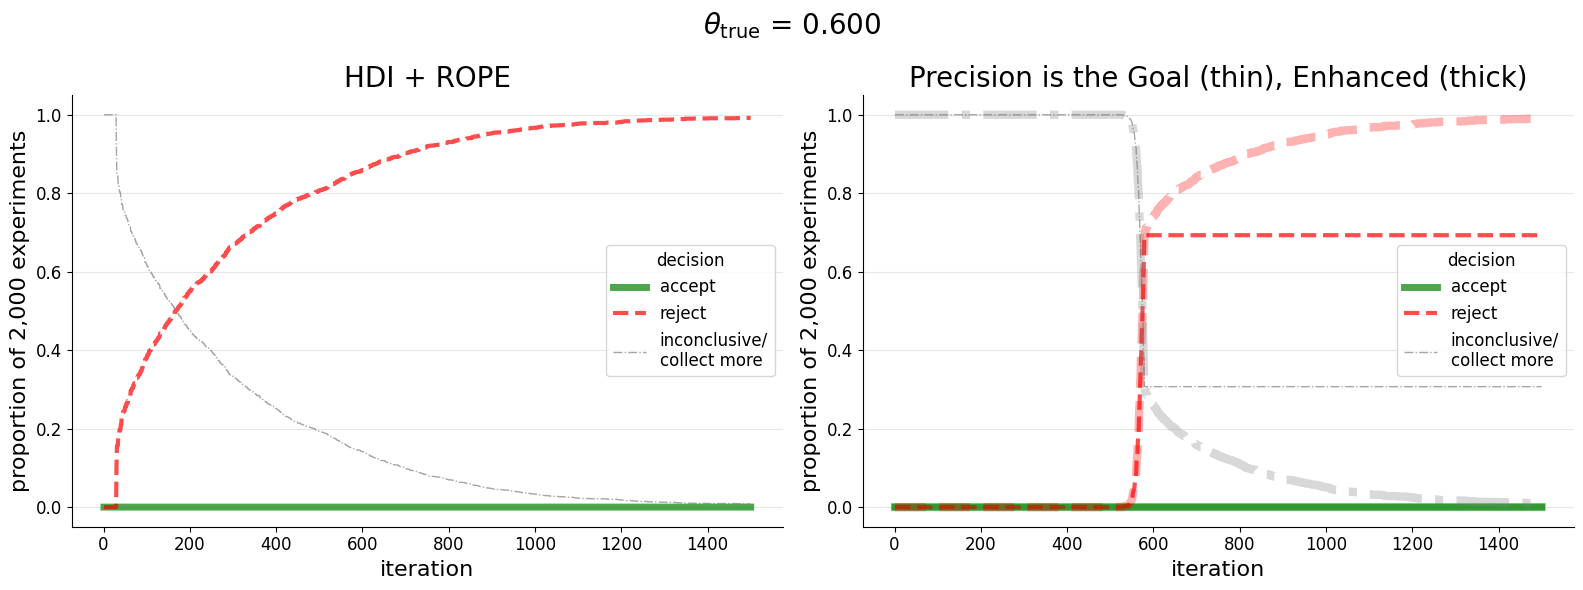

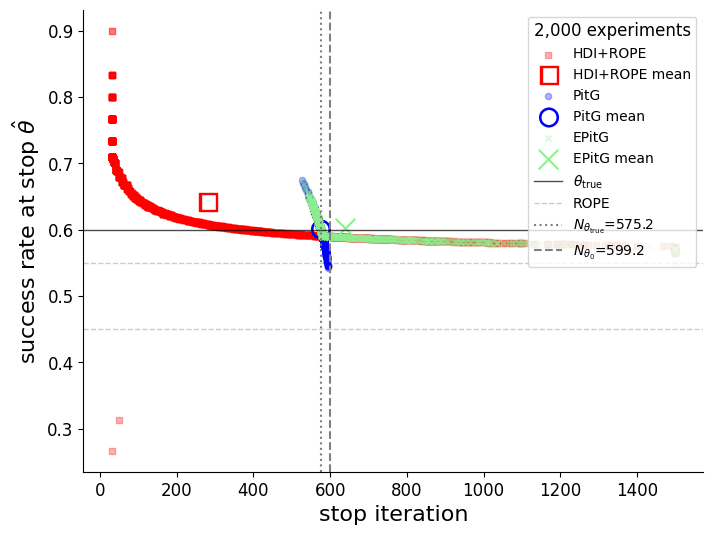

In [76]:
hypothesis_0pt5_true0pt6.plot_decision_rates(synth_0pt6.success_rate)
plt.show()
hypothesis_0pt5_true0pt6.plot_stop_iter_sample_rates(success_rate=synth_0pt6.success_rate, title=None)
plt.show()

In [77]:
%%time

synth_0pt57 = BinomialSimulation(success_rate=0.57, n_experiments=2000)
hypothesis_0pt5_true0pt57 = BinomialHypothesis()
hypothesis_0pt5_true0pt57.run_hypothesis_on_experiments(synth_0pt57.experiments, binary_accounting)

Generating synthetic data with parameter values:
0.57: true success rate
2000: experiments
1500: sample size per experiment
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal
Sample 0 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 840, 'failures': 660, 'hdi_min': 0.534867547044455, 'hdi_max': 0.5850835156227976, 'precision_goal_achieved': True}
Sample 1 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 853, 'failures': 647, 'hdi_min': 0.5435971864178839, 'hdi_max': 0.5936992132066574, 'precision_goal_achieved': True}
Sample 2 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 859, 'failures': 641, 

,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0080,0.6480,0.6560,0.3440,804.6165,611.021115,0.604697,0.058295
pitg,0.0005,0.1570,0.1575,0.8425,586.4470,7.116144,0.570288,0.020308
epitg,0.0035,0.5415,0.5450,0.4550,1127.1755,395.941462,0.575583,0.017217


CPU times: user 1min 7s, sys: 619 ms, total: 1min 8s
Wall time: 1min 8s


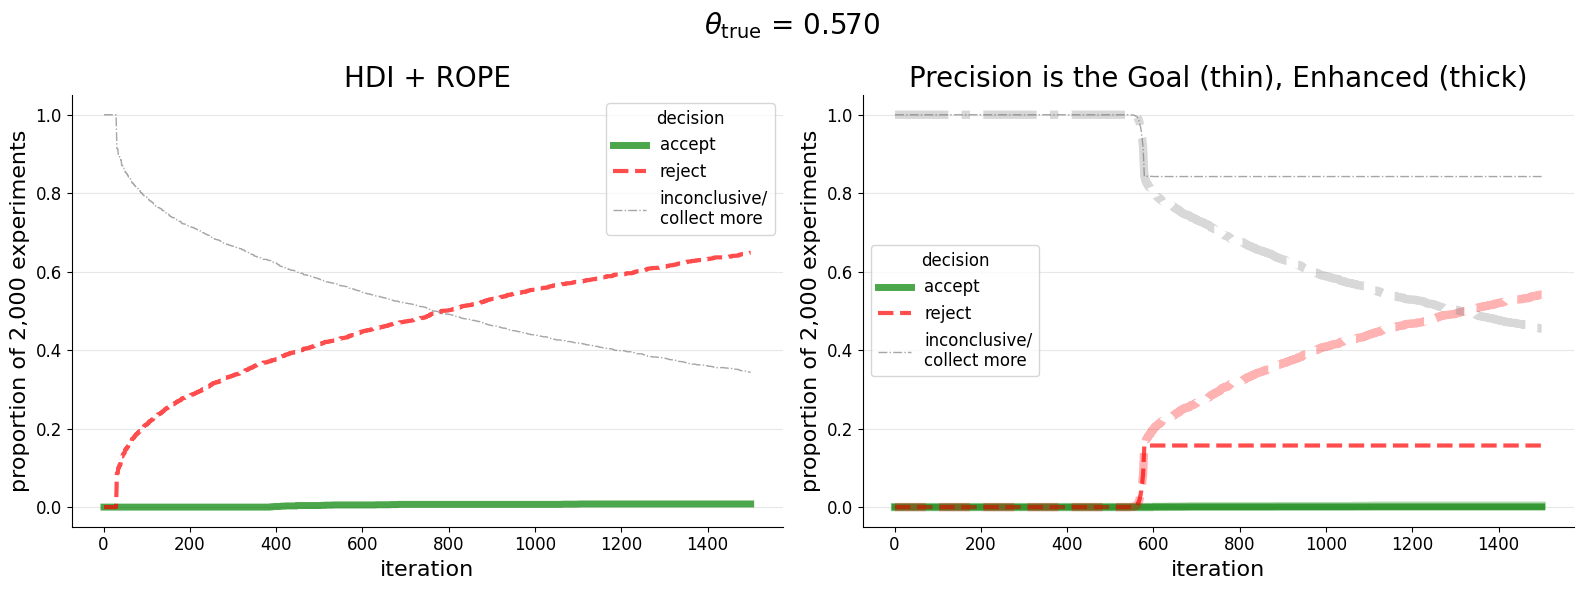

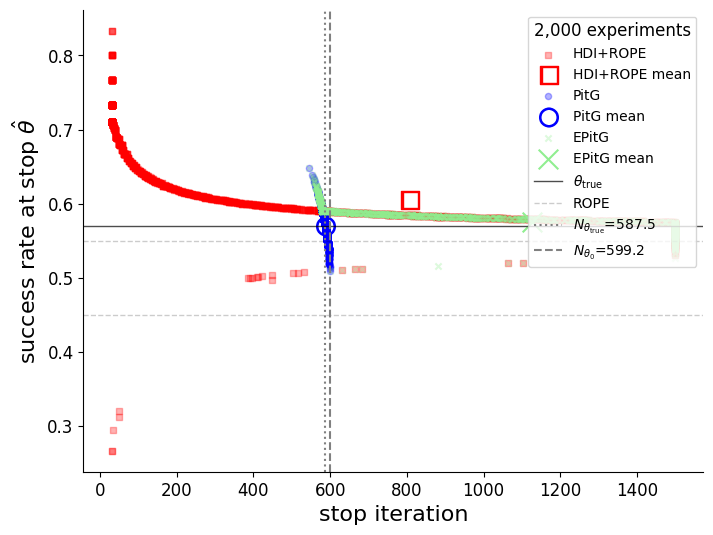

In [78]:
hypothesis_0pt5_true0pt57.plot_decision_rates(synth_0pt57.success_rate)
plt.show()
hypothesis_0pt5_true0pt57.plot_stop_iter_sample_rates(success_rate=synth_0pt57.success_rate, title=None)
plt.show()

In [79]:
print("True = 0.57")
print("-" * 40)
report_success_rates_multiple_algos(hypothesis_0pt5_true0pt57.method_df_stats.copy())

True = 0.57
----------------------------------------
pitg
overall         0.570288
conclusive      0.601331
inconclusive    0.564484
accept          0.509182
reject          0.601625
dtype: float64
----------------------------------------
epitg
overall         0.575583
conclusive      0.588071
inconclusive    0.560624
accept          0.514473
reject          0.588546
dtype: float64
----------------------------------------
hdi_rope
overall         0.604697
conclusive      0.627897
inconclusive    0.560453
accept          0.506296
reject          0.629398
dtype: float64
----------------------------------------


In [80]:
def full_analysis(binary_accounting, success_rate_true=0.5, success_rate_null=0.5, dsuccess_rate=0.05):
    synth = BinomialSimulation(success_rate=success_rate_true)
    hypothesis = BinomialHypothesis(success_rate_null=success_rate_null,dsuccess_rate=dsuccess_rate)
    hypothesis.run_hypothesis_on_experiments(synth.experiments, binary_accounting)
    hypothesis.plot_decision_rates(synth.success_rate)
    plt.show()
    hypothesis.plot_stop_iter_sample_rates(success_rate=synth.success_rate, title=None)
    plt.show()
    report_success_rates_multiple_algos(hypothesis.method_df_stats.copy())

Generating synthetic data with parameter values:
0.85: true success rate
500: experiments
1500: sample size per experiment
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0,1.0,1.0,0.0,30.10,0.763653,0.854126,0.062889
pitg,0.0,1.0,1.0,0.0,291.45,52.206038,0.855714,0.028154
epitg,0.0,1.0,1.0,0.0,291.45,52.206038,0.855714,0.028154


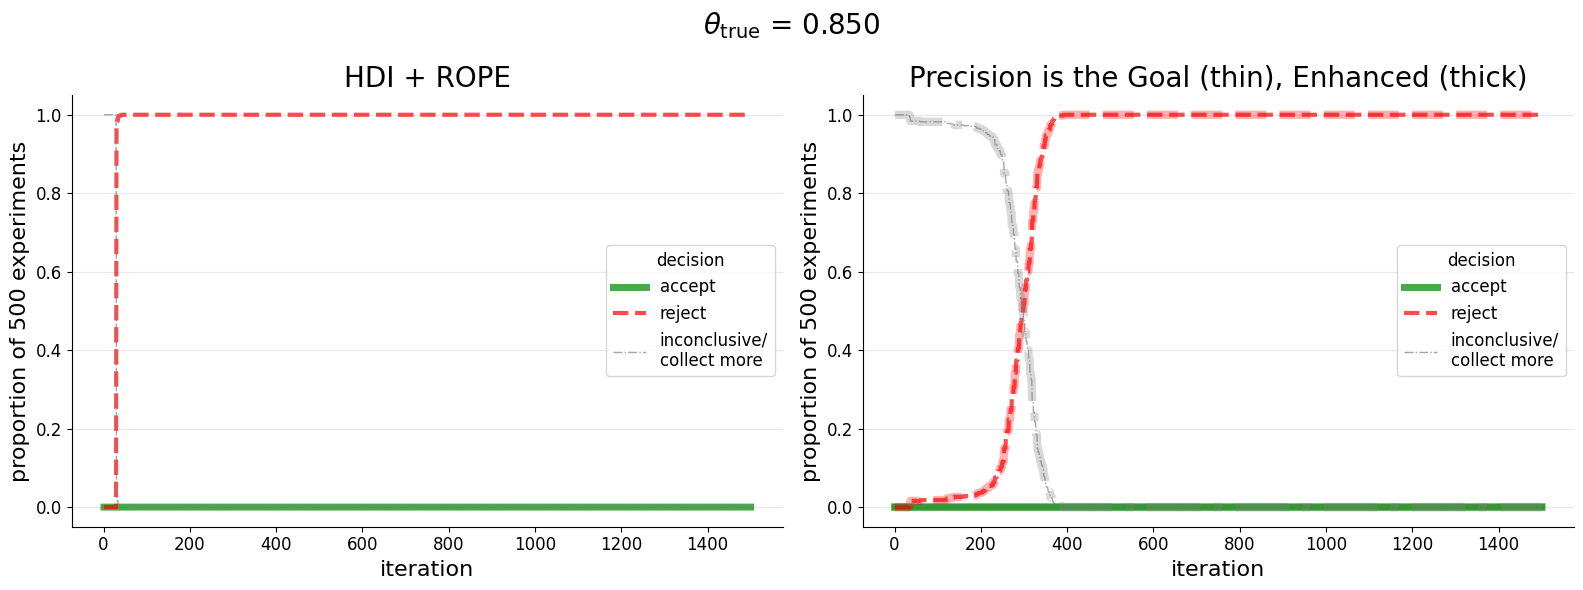

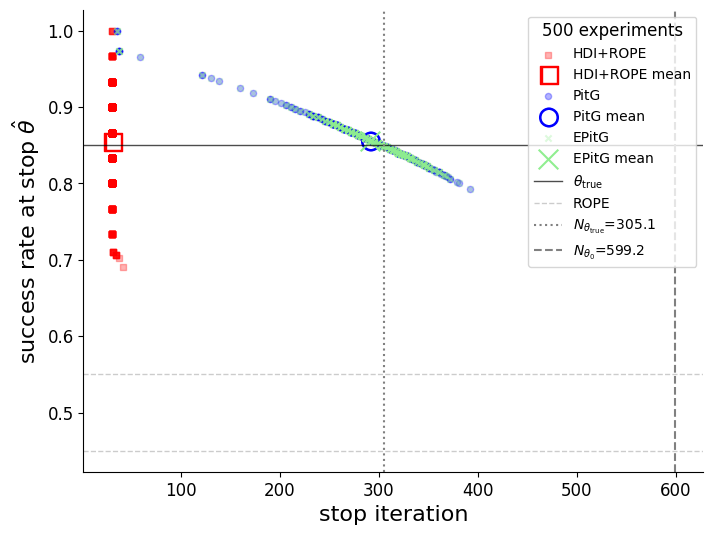

pitg
overall         0.855714
conclusive      0.855714
inconclusive         NaN
accept               NaN
reject          0.855714
dtype: float64
----------------------------------------
epitg
overall         0.855714
conclusive      0.855714
inconclusive         NaN
accept               NaN
reject          0.855714
dtype: float64
----------------------------------------
hdi_rope
overall         0.854126
conclusive      0.854126
inconclusive         NaN
accept               NaN
reject          0.854126
dtype: float64
----------------------------------------
CPU times: user 31 s, sys: 535 ms, total: 31.6 s
Wall time: 30.8 s


In [81]:
%%time

full_analysis(binary_accounting, success_rate_true=0.85)

Generating synthetic data with parameter values:
0.85: true success rate
500: experiments
1500: sample size per experiment
0.75: null hypothesis
0.7: ROPE min
0.8: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0,1.000,1.000,0.000,144.786,163.106529,0.881056,0.036265
pitg,0.0,0.676,0.676,0.324,291.450,52.206038,0.855714,0.028154
epitg,0.0,1.000,1.000,0.000,329.226,133.545527,0.857701,0.025923


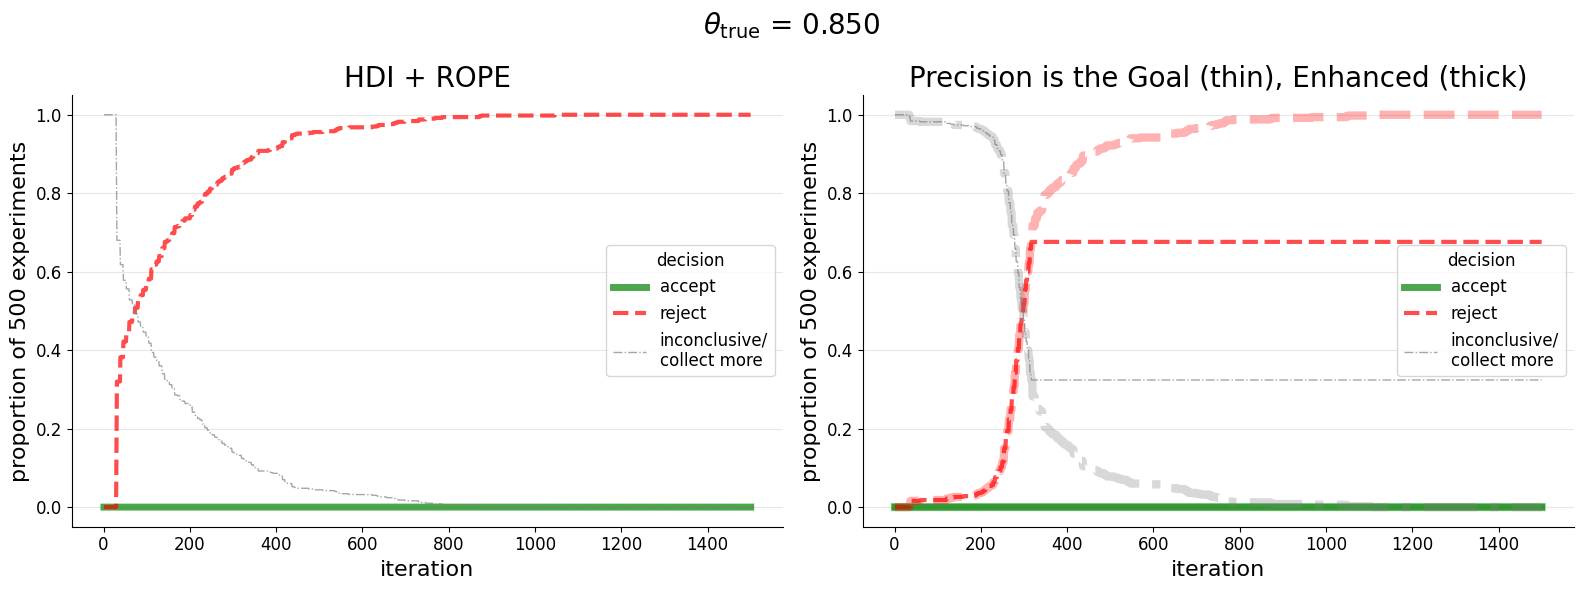

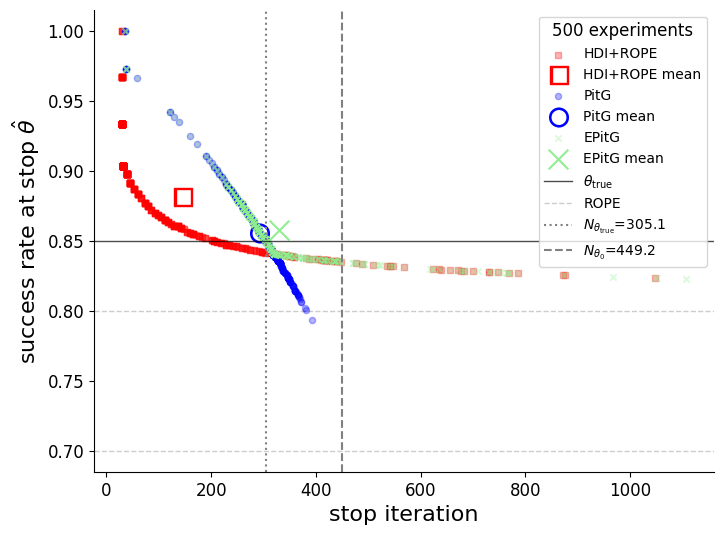

pitg
overall         0.855714
conclusive      0.868177
inconclusive    0.829709
accept               NaN
reject          0.868177
dtype: float64
----------------------------------------
epitg
overall         0.857701
conclusive      0.857701
inconclusive         NaN
accept               NaN
reject          0.857701
dtype: float64
----------------------------------------
hdi_rope
overall         0.881056
conclusive      0.881056
inconclusive         NaN
accept               NaN
reject          0.881056
dtype: float64
----------------------------------------
CPU times: user 28 s, sys: 755 ms, total: 28.7 s
Wall time: 27.6 s


In [82]:
%%time

full_analysis(binary_accounting, success_rate_true=0.85, success_rate_null=0.75, dsuccess_rate=0.05)

# Quantfiying Uncertainty

In [68]:
df_count_stats = pd.DataFrame(binary_accounting.dict_successes_failures_hdi_limits).T
df_count_stats = df_count_stats.reset_index().rename(columns={"level_0": "a", "level_1": "b", 0: "hdi_min", 1: "hdi_max"})
df_count_stats["hdi_width"] = df_count_stats["hdi_max"] - df_count_stats["hdi_min"]
df_count_stats['n'] = df_count_stats['a'] + df_count_stats['b']
df_count_stats.sort_values(["n", "a"], inplace=True)

df_count_stats.index.name = "tally"

df_count_stats.head(4)

,a,b,hdi_min,hdi_max
tally,,,,
0,0,1,0.000000,0.776393
1,1,1,0.050000,1.000000
2,2,1,0.223607,1.000000
3,3,1,0.368403,1.000000


In [76]:
# apply  beta.var(a_, b_) to columns a and b

df_count_stats['var'] = df_count_stats.apply(lambda x: beta.var(x["a"], x["b"]), axis=1)

In [81]:
df_count_stats['std'] = df_count_stats['var'].apply(lambda x: np.sqrt(x))

In [109]:
df_count_stats["n"].astype(float)/ 20.


tally
0          0.05
640        0.05
3690       0.10
1          0.10
1196       0.10
          ...  
103260    75.00
105512    75.00
81546     75.00
105147    75.00
80207     75.00
Name: n, Length: 106863, dtype: float64

In [117]:
df_count_stats.tail(4)

,a,b,hdi_min,hdi_max,var,hdi_width,std,n
tally,,,,,,,,
105512,858,642,0.546950,0.597004,0.000163,0.050054,0.012771,1500
81546,859,641,0.547621,0.597665,0.000163,0.050044,0.012769,1500
105147,860,640,0.548292,0.598326,0.000163,0.050034,0.012766,1500
80207,861,639,0.548963,0.598987,0.000163,0.050024,0.012764,1500


In [119]:
df_count_stats.tail(4)["std"] * 1.96 * 2

tally
105512    0.050063
81546     0.050053
105147    0.050043
80207     0.050033
Name: std, dtype: float64

In [ ]:
a_ = 861
b_ = 639

In [116]:
0.012764 * 1.96*2

0.05003488

Text(0, 0.5, 'hdi_width')

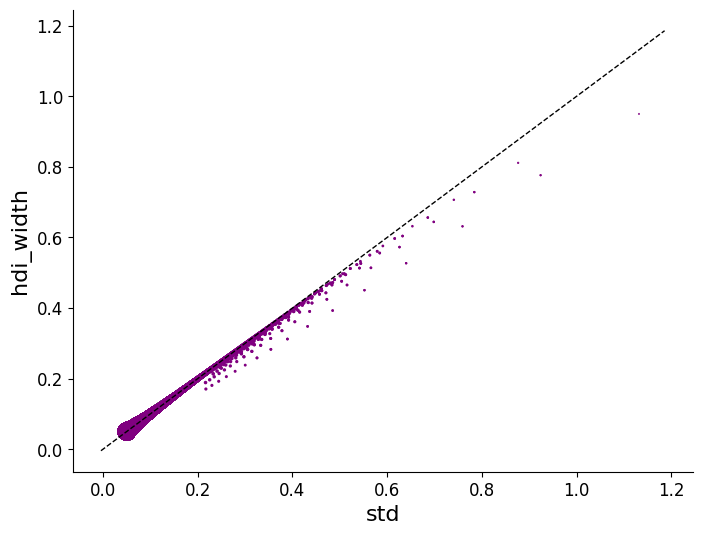

In [122]:
plt.scatter(df_count_stats['std'] * 1.96 * 2, df_count_stats["hdi_width"], s=df_count_stats["n"] / 10., color="purple")

plot_parity_line()
plt.xlabel("std")
plt.ylabel("hdi_width")

Text(0, 0.5, '$\\log_{10}(diff)$')

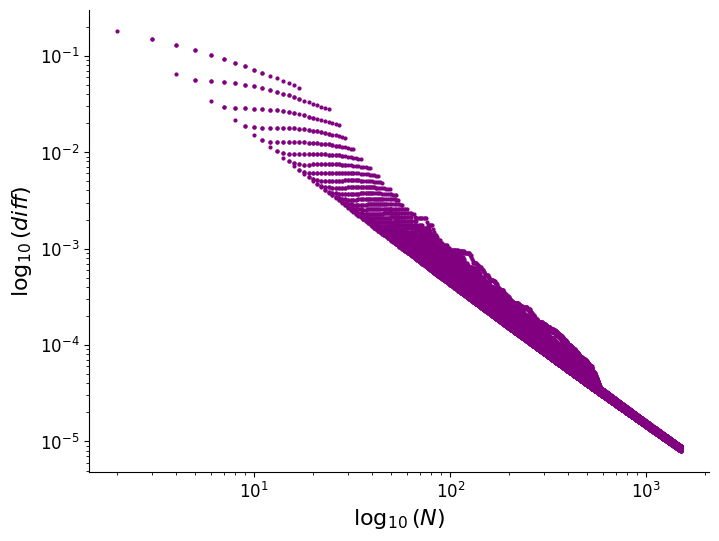

In [139]:
factor_ = 1.96 * 2   # 1.96 for 95% CI, 2 for two-tailed

sr_diff = df_count_stats['std'] * factor_ -  df_count_stats["hdi_width"]
sr_frac = sr_diff/ df_count_stats["hdi_width"]


plt.scatter(df_count_stats["n"], sr_diff, color="purple", s=4)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\log_{10}(N)$")
plt.ylabel(r"$\log_{10}(diff)$")

Text(0, 0.5, '$\\log_{10}(\\%)$')

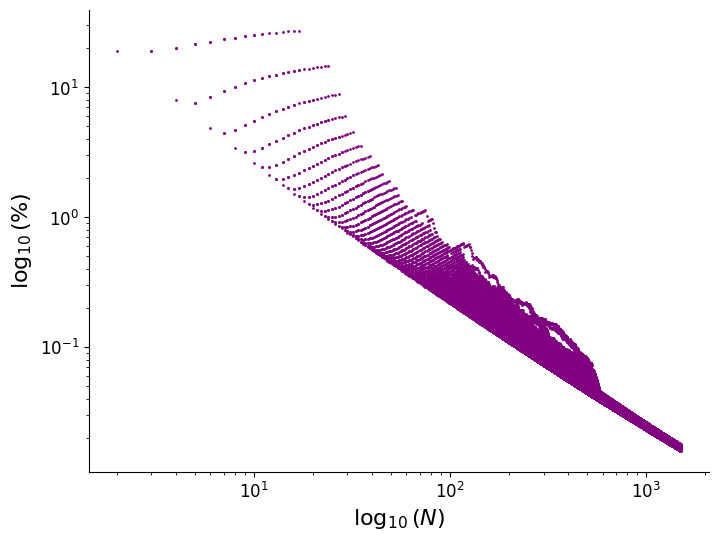

In [146]:
plt.scatter(df_count_stats["n"], sr_frac * 100., color="purple", s=1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\log_{10}(N)$")
plt.ylabel(r"$\log_{10}(\%)$")

In [123]:
plt.scatter(df_count_stats['std'] * 1.96 * 2, df_count_stats["hdi_width"], s=df_count_stats["n"] / 10., color="purple")

plot_parity_line()
plt.xlabel("std")
plt.ylabel("hdi_width")

tally
0              NaN
640            NaN
3690           NaN
1         1.131607
1196           NaN
            ...   
103260    0.050073
105512    0.050063
81546     0.050053
105147    0.050043
80207     0.050033
Name: std, Length: 106863, dtype: float64

In [83]:
df_count_stats.tail(4)

,a,b,hdi_min,hdi_max,var,hdi_width,std
tally,,,,,,,
106859,607,440,0.549832,0.609586,0.000232,0.059754,0.015247
106860,608,440,0.550250,0.609968,0.000232,0.059718,0.015238
106861,833,622,0.547077,0.597890,0.000168,0.050814,0.012965
106862,624,467,0.542577,0.601258,0.000224,0.058681,0.014973


In [ ]:
variances = []
hdi_widths = []
as_ = []
bs_ = []

for a_, b_ in binary_accounting.dict_successes_failures_hdi_limits.keys():
    if a_ >= 10 and b_ >= 10:
        variances.append(beta.var(a_, b_))
        hdi_min, hdi_max = binary_accounting.dict_successes_failures_hdi_limits[(a_, b_)]
        hdi_widths.append(hdi_max - hdi_min)
        as_.append(a_)
        bs_.append(b_)

variances = np.array(variances)
hdi_widths = np.array(hdi_widths)
ns_ = np.array(ns_)

# Old Scripts
Consider deleting

In [45]:
# https://en.wikipedia.org/wiki/Beta_distribution
alpha_, beta_ =  300, 300
alpha_beta__squared = (alpha_ + beta_) ** 2
variance_ = alpha_ * beta_ / ( alpha_beta__squared * (alpha_ + beta_ + 1))

np.sqrt(variance_) * 1.95 * 2

0.0795421591036804

In [4]:
success_rate_null = 0.5   # this is the null hypothesis, not necessarilly true
dsuccess_rate = 0.05 #success_rate * 0.1
rope_precision_fraction = 0.8

success_rate = 0.5  #0.65  #0.5 + 0.5 * dsuccess_rate  # the true value
# --------

rope_min = success_rate_null - dsuccess_rate
rope_max = success_rate_null + dsuccess_rate

# hypothesis: if precision_goal is lower, then PitG has less of
# an inconclusiveness problem but at the expense of more trials.
precision_goal = (2 * dsuccess_rate) * rope_precision_fraction
#precision_goal = (dsuccess_rate) * rope_precision_fraction # 1500 was not enough for 0.04
#precision_goal = (1.5 * dsuccess_rate) * rope_precision_fraction # 1500 was not enough for 0.04


print(f"{success_rate_null:0.5}: null")
print(f"{rope_min:0.2}: ROPE min")
print(f"{rope_max:0.2}: ROPE max")
print("-" * 20)
print(f"{precision_goal:0.2}: Precision Goal")
print("-" * 20)
print(f"{success_rate:0.3}: true")

0.5: null
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal
--------------------
0.5: true


In [46]:
experiments = 500 # number of experiments 500 #200 #300 #200
n_samples = 1500  #2500 # max number of samples in each experiement #2500 #1000 #1500

np.random.seed(seed)
samples = np.random.binomial(1, success_rate, [experiments, n_samples])

samples.shape  # (experiments, n_samples)

(500, 1500)

# Enhanced Precision is the Goal

As compared to "Precision is the Goal" and HDI+ROPE.

In [47]:
# binary_accounting = BinaryAccounting()

In [48]:
method_stats, method_roperesult_iteration = stop_decision_multiple_experiments_multiple_methods(samples, rope_min, rope_max, precision_goal, binary_accounting=binary_accounting)

Sample 140 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 708, 'failures': 792, 'hdi_min': 0.446766867411269, 'hdi_max': 0.4972694566161049}
Sample 165 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 809, 'failures': 691, 'hdi_min': 0.5141054692980911, 'hdi_max': 0.5645305410768443}
Sample 169 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 698, 'failures': 802, 'hdi_min': 0.4401126621762446, 'hdi_max': 0.4905728257358288}
Sample 171 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 705, 'failures': 795, 'hdi_min': 0.44

In [49]:
# examining uniqueness distributions of success and failure pairs
100. * pd.Series(binary_accounting.dict_successes_failures_counter).value_counts(normalize=True).sort_index()

1      31.374649
2      13.900983
3       7.907303
4       5.540730
5       4.216994
         ...    
209     0.001756
216     0.001756
250     0.001756
253     0.001756
287     0.001756
Name: proportion, Length: 129, dtype: float64

In [50]:
method_df_stats = {method_name: stats_dict_to_df(method_stats[method_name]) for method_name in method_stats}

method_df_stats["hdi_rope"]

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,precision,success_rate
experiment_number,,,,,,,,,,,,
0,424,True,False,False,True,False,211,213,0.45014,0.545164,0.095024,0.497642
1,443,True,False,False,True,False,223,220,0.456903,0.549872,0.092969,0.503386
2,794,True,False,False,True,False,409,385,0.48037,0.549832,0.069462,0.515113
3,597,True,False,False,True,False,293,304,0.450736,0.530843,0.080107,0.490787
4,445,True,False,False,True,False,224,221,0.456992,0.549753,0.092761,0.503371
...,...,...,...,...,...,...,...,...,...,...,...,...
495,1157,True,False,False,True,False,554,603,0.450073,0.507607,0.057534,0.478825
496,1075,True,False,False,True,False,516,559,0.450169,0.50986,0.059691,0.48
497,845,True,False,False,True,False,436,409,0.482297,0.54963,0.067334,0.515976


In [51]:
method_df_iteration_counts = {method_name: iteration_counts_to_df(method_roperesult_iteration[method_name], experiments) for method_name in method_roperesult_iteration}

method_df_iteration_counts["hdi_rope"]

,iteration,accept,reject_below,reject_above,reject,inconclusive
0,1,0,0,0,0,500
1,2,0,0,0,0,500
2,3,0,0,0,0,500
3,4,0,0,0,0,500
4,5,0,14,13,27,473
...,...,...,...,...,...,...
1495,1496,373,62,59,121,6
1496,1497,373,62,59,121,6
1497,1498,373,62,59,121,6
1498,1499,373,62,59,121,6


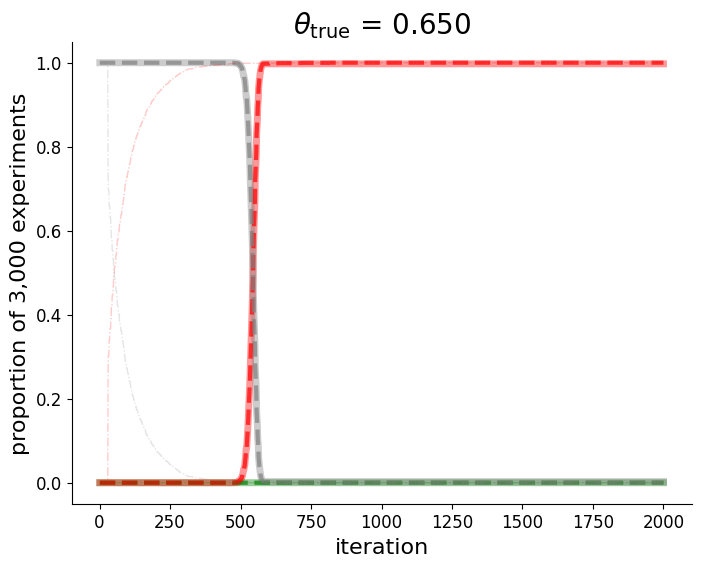

In [200]:
plot_multiple_decision_rates_jammed(method_df_iteration_counts, success_rate, experiments, iteration_values=None)

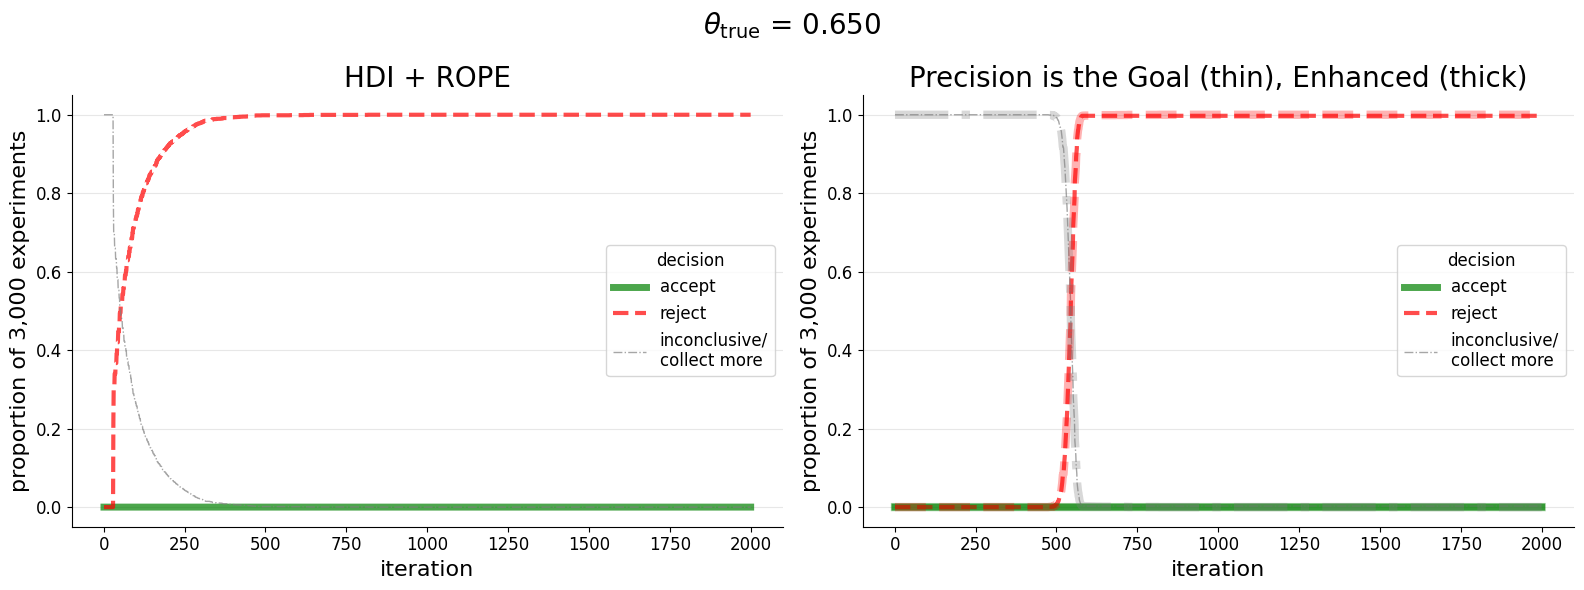

In [199]:
viz_epitg = True
plot_multiple_decision_rates_separate(method_df_iteration_counts, success_rate, experiments, viz_epitg=viz_epitg, iteration_values=None)

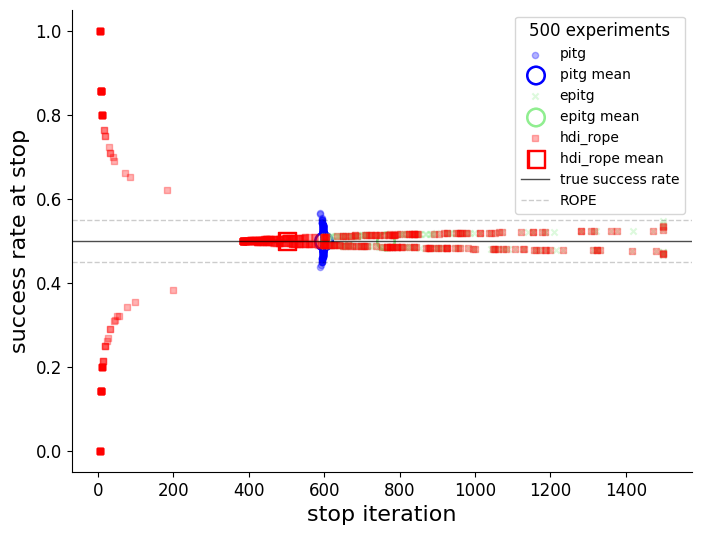

In [54]:
scatter_stop_iter_sample_rate(method_df_stats, rope_min=rope_min, rope_max=rope_max, success_rate_true=success_rate, title=None)

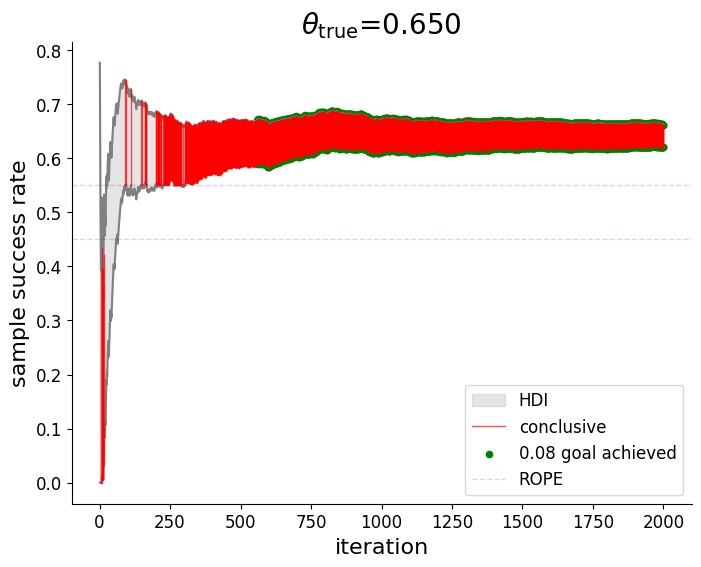

In [197]:
isample  = 2

df_sample_results = sample_all_iterations_results(samples[isample, :], precision_goal, rope_min, rope_max, binary_accounting=binary_accounting, iteration_number=None)

viz_one_sample_results(df_sample_results, precision_goal, rope_min, rope_max, success_rate=success_rate)

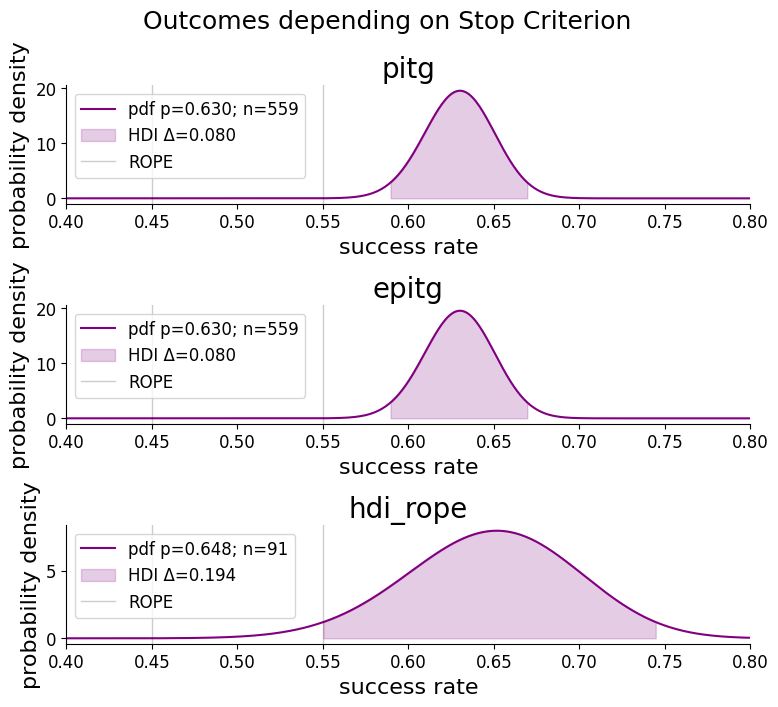

In [203]:
xlim = (0.4,0.8)
plot_sample_pdf_methods(method_df_stats, isample, rope_min, rope_max, xlim=xlim, method_names=None)


# Old Scripts
Some still useful!

In [28]:
dict_successes_failures_hdi_limits = {}
dict_successes_failures_counter = {}

def _update_iteration_tally(iteration_dict, iteration):
    for this_iteration in range(iteration, len(iteration_dict)+1):
        iteration_dict[this_iteration] += 1

def booleans_to_rope_result(decision_accept, decision_reject_below, decision_reject_above):
    if decision_accept:
        return "within"
    elif decision_reject_below:
        return "below"
    elif decision_reject_above:
        return "above"

def successes_failures_to_hdi_limits(successes, failures):

    pair = (successes, failures)
    if pair not in dict_successes_failures_hdi_limits:
        dict_successes_failures_hdi_limits[pair] =\
            successes_failures_caculate_hdi_limits(successes, failures)
        dict_successes_failures_counter[pair] = 1
    else:
        dict_successes_failures_counter[pair] += 1

    return dict_successes_failures_hdi_limits[pair]


def successes_failures_caculate_hdi_limits(successes, failures):
    aa = int(successes)
    bb = int(failures)
    
    if not failures:
        aa += 1
        bb += 1
        
    if not successes:
        aa += 1
        bb += 1

    hdi_min, hdi_max = successes_failures_to_hdi_ci_limits(aa, bb)

    return hdi_min, hdi_max

In [29]:
# For each method and rope result type creating tally of outcomes

method_roperesult_iteration = {}
methods = ["pitg", "epitg", "hdi_rope"]
rope_results = ["within", "below", "above"]
for method in methods:
    method_roperesult_iteration[method] = {}
    for rope_result in rope_results:
        method_roperesult_iteration[method][rope_result] = {iteration: 0 for iteration in range(1, n_samples + 1)}

print(method, rope_result)
len(method_roperesult_iteration[method][rope_result])

hdi_rope above


1500

In [30]:
iteration_number = np.arange(1, n_samples + 1)

method_stats = {"pitg": {}, "epitg": {}, "hdi_rope": {}}

for isample, sample in enumerate(samples):
    pitg_stopped = False
    hdi_rope_stopped = False

    iteration_successes = sample.cumsum()
    iteration_failures = iteration_number - iteration_successes

    for iteration, successes, failures in zip(iteration_number, iteration_successes, iteration_failures):
        final_iteration = iteration == iteration_number[-1]
        hdi_min, hdi_max = successes_failures_to_hdi_limits(successes, failures)
        #hdi_min, hdi_max = successes_failures_caculate_hdi_limits(successes, failures)

        # has the precision goal been achieved?
        precision_goal_achieved = (hdi_max - hdi_min) < precision_goal

        # is the HDI conclusively within or outside the ROPE?
        decision_accept = (hdi_min >= rope_min) & (hdi_max <= rope_max)
        decision_reject_below = hdi_max < rope_min  
        decision_reject_above = rope_max < hdi_min
        conclusive = decision_accept | decision_reject_above | decision_reject_below

        iteration_results = {"decision_iteration": iteration,
                                                 "accept": decision_accept,
                                                    "reject_below": decision_reject_below,
                                                    "reject_above": decision_reject_above,
                                                    "conclusive": conclusive,
                                                    "inconclusive": not conclusive,
                                                    "successes": successes,
                                                    "failures": failures,
                                                    "hdi_min": hdi_min,
                                                    "hdi_max": hdi_max,
                                                 }   

        if precision_goal_achieved:

            # update Precision Is The Goal Stop
            if pitg_stopped is False:
                # not applying `break` because we continue for ePiTG
                if conclusive:
                    rope_result = booleans_to_rope_result(decision_accept, decision_reject_below, decision_reject_above)
                    _update_iteration_tally(method_roperesult_iteration["pitg"][rope_result], iteration)
                method_stats["pitg"][isample] = iteration_results
                pitg_stopped = True  # sample does not continue with PITG (only ePiTG) 

            # continue with Enhance Precision Is The Goal
            if conclusive:
                rope_result = booleans_to_rope_result(decision_accept, decision_reject_below, decision_reject_above)
                _update_iteration_tally(method_roperesult_iteration["epitg"][rope_result], iteration)

                if hdi_rope_stopped is False:
                    _update_iteration_tally(method_roperesult_iteration["hdi_rope"][rope_result], iteration)
                    
            if conclusive | final_iteration:
                method_stats["epitg"][isample] = iteration_results

                if hdi_rope_stopped is False:
                    method_stats["hdi_rope"][isample] = iteration_results
                    hdi_rope_stopped = True

                if final_iteration:
                    print(f"Sample {isample} at final iteration")
                    print(method_stats["epitg"][isample])
                break
        
        elif conclusive & (hdi_rope_stopped is False):
            # case in which precision not achieved yet but conclusive.
            # this is the HDI+ROPE approach which disregards precision
            rope_result = booleans_to_rope_result(decision_accept, decision_reject_below, decision_reject_above)
            _update_iteration_tally(method_roperesult_iteration["hdi_rope"][rope_result], iteration)
            method_stats["hdi_rope"][isample] = iteration_results

            hdi_rope_stopped = True

        elif final_iteration:
            # ensures that if reached final iteration and not conclusive that
            # results are still recorded as inconclusive
            
            """
            decision_accept = False
            decision_reject_below = False
            decision_reject_above = False
            conclusive = False
            """
            if isample not in method_stats["hdi_rope"]:
               method_stats["hdi_rope"][isample] = iteration_results
            if isample not in method_stats["pitg"]:
                method_stats["pitg"][isample] = iteration_results
            if isample not in method_stats["epitg"]:
                method_stats["epitg"][isample] = iteration_results
            break

In [ ]:
# examining uniqueness distributions of success and failure pairs
pd.Series(dict_successes_failures_counter).value_counts(normalize=True).sort_index()

In [ ]:
def stats_dict_to_df(method_stats):
    df = pd.DataFrame(method_stats).T
    df.index.name = "experiment_number"
    df["precision"] = df["hdi_max"] - df["hdi_min"]
    df["success_rate"] = df["successes"] / (df["successes"] + df["failures"])
    return df


df_stats_epitg = stats_dict_to_df(method_stats["epitg"])
print(df_stats_epitg.shape)
df_stats_epitg.head(4)

In [ ]:
df_stats_pitg = stats_dict_to_df(method_stats["pitg"])
print(df_stats_pitg.shape)
df_stats_pitg.head(4)

In [ ]:
df_stats_hdirope = stats_dict_to_df(method_stats["hdi_rope"])
print(df_stats_hdirope.shape)
df_stats_hdirope.head(4)

In [ ]:
df_stats_pitg.equals(df_stats_epitg)

In [ ]:
def iteration_counts_to_df(roperesult_iteration, experiments):
    df = pd.DataFrame({
        "iteration": list(roperesult_iteration["within"].keys()),
        "accept": list(roperesult_iteration["within"].values()),
        "reject_below": list(roperesult_iteration["below"].values()),
        "reject_above": list(roperesult_iteration["above"].values())
    })

    df['reject'] = df['reject_above'] + df['reject_below']
    df['inconclusive'] = experiments - df['accept'] - df['reject']

    return df

df_pitg_counts = iteration_counts_to_df(method_roperesult_iteration["pitg"], experiments)
df_epitg_counts = iteration_counts_to_df(method_roperesult_iteration["epitg"], experiments)
df_hdirope_counts = iteration_counts_to_df(method_roperesult_iteration["hdi_rope"], experiments)


df_epitg_counts.head(4)

In [ ]:
df_epitg_counts.describe()

In [ ]:
df_pitg_counts.describe()

In [ ]:
df_hdirope_counts.describe()

In [ ]:
df_pitg_counts.equals(df_epitg_counts)

In [ ]:
title = f"true success rate = {success_rate:0.3f}"
xlabel = "iteration"

iteration_values = df_pitg_counts["iteration"]

# plotting HDI+ROPE
alpha, linewidth, linestyle = 0.2, 1, "-."
plt.plot(iteration_values, df_hdirope_counts['accept'] / experiments, color="green", linewidth=linewidth, alpha=alpha, linestyle=linestyle)
plt.plot(iteration_values, df_hdirope_counts['reject'] / experiments, color="red", linewidth=linewidth, alpha=alpha, linestyle=linestyle)
plt.plot(iteration_values, df_hdirope_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth, alpha=alpha, linestyle=linestyle)


# plotting pitg
alpha, linewidth = 0.4, 5
plt.plot(iteration_values, df_pitg_counts['accept'] / experiments, color="green", linewidth=linewidth, alpha=alpha)
plt.plot(iteration_values, df_pitg_counts['reject'] / experiments, color="red", linewidth=linewidth, alpha=alpha)
plt.plot(iteration_values, df_pitg_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth, alpha=alpha)

# plotting epitg
alpha, linewidth, linestyle = 0.7, 3, "--"
plt.plot(iteration_values, df_epitg_counts['accept'] / experiments, color="green", linewidth=linewidth, alpha=alpha, linestyle=linestyle)
plt.plot(iteration_values, df_epitg_counts['reject'] / experiments, color="red", linewidth=linewidth, alpha=alpha, linestyle=linestyle)
plt.plot(iteration_values, df_epitg_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth, alpha=alpha, linestyle=linestyle)


#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(xlabel)
plt.ylabel(f"proportion of {experiments:,} experiments")
plt.title(title)

In [ ]:
plt.figure(figsize=(FIG_WIDTH * 2, FIG_HEIGHT))

viz_epitg = True

suptitle = f"true success rate = {success_rate:0.3f}"
alpha=0.7

linestyle_accept, linewidth_accept = None, 5
linestyle_reject, linewidth_reject = "--", 3
linestyle_inconclusive, linewidth_inconclusive = "-.", 1


plt.subplot(1, 2, 1)

# plotting HDI+ROPE
plt.plot(iteration_values, df_hdirope_counts['accept'] / experiments, color="green", linewidth=linewidth_accept, alpha=alpha, linestyle=linestyle_accept, label="accept")
plt.plot(iteration_values, df_hdirope_counts['reject'] / experiments, color="red", linewidth=linewidth_reject, alpha=alpha, linestyle=linestyle_reject, label="reject")
plt.plot(iteration_values, df_hdirope_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth_inconclusive, alpha=alpha, linestyle=linestyle_inconclusive, label="inconclusive/\ncollect more")

plt.legend(title="decision")
plt.xlabel(xlabel)
plt.ylabel(f"proportion of {experiments:,} experiments")
plt.title("HDI + ROPE")


plt.subplot(1, 2, 2)

# plotting PitG
plt.plot(iteration_values, df_pitg_counts['accept'] / experiments, color="green", linewidth=linewidth_accept, alpha=alpha, linestyle=linestyle_accept, label="accept")
plt.plot(iteration_values, df_pitg_counts['reject'] / experiments, color="red", linewidth=linewidth_reject, alpha=alpha, linestyle=linestyle_reject, label="reject")
plt.plot(iteration_values, df_pitg_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth_inconclusive, alpha=alpha, linestyle=linestyle_inconclusive, label="inconclusive/\ncollect more")

if viz_epitg:
    linewidth_epitg, alpha_epitg = 6, 0.3
    plt.plot(iteration_values, df_epitg_counts['accept'] / experiments, color="green", linewidth=linewidth_epitg, alpha=alpha_epitg, linestyle=linestyle_accept, label=None)
    plt.plot(iteration_values, df_epitg_counts['reject'] / experiments, color="red", linewidth=linewidth_epitg, alpha=alpha_epitg, linestyle=linestyle_reject, label=None)
    plt.plot(iteration_values, df_epitg_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth_epitg, alpha=alpha_epitg, linestyle=linestyle_inconclusive, label=None)
    plt.title("Precision is the Goal (thin), Enhanced (thick)")
else:
    plt.title("Precision is the Goal")


plt.legend(title="decision")
plt.xlabel(xlabel)
plt.ylabel(f"proportion of {experiments:,} experiments")


plt.suptitle(suptitle, fontsize=20)
plt.tight_layout()

In [ ]:
df_hdirope_counts.drop(["iteration", "reject"], axis=1).sum(axis=1).value_counts()

In [ ]:
import seaborn as sns

df_plot = df_stats_hdirope[["decision_iteration", "success_rate"]]
df_plot["method"] = "HDI + ROPE"
df_append = df_stats_pitg[["decision_iteration", "success_rate"]]
df_append["method"] = "PitG"
df_plot = pd.concat([df_plot, df_append])
df_append = df_stats_epitg[["decision_iteration", "success_rate"]]
df_append["method"] = "ePiTG"
df_plot = pd.concat([df_plot, df_append])

In [ ]:
sns.jointplot(x=df_plot["decision_iteration"], y=df_plot["success_rate"], color="#4CB391", hue=df_plot["method"])

In [ ]:
plt.figure(figsize=(FIG_WIDTH, 0.5 * FIG_HEIGHT))

all_values = np.concatenate([df_stats_epitg["decision_iteration"], df_stats_pitg["decision_iteration"], df_stats_hdirope["decision_iteration"] ])

_, bins = np.histogram(all_values, bins=100)

plt.hist(df_stats_pitg["decision_iteration"], bins=bins, histtype='step', label="PitG", color="orange")
plt.hist(df_stats_epitg["decision_iteration"], bins=bins, histtype='step', label="ePitG", color="purple")   
plt.hist(df_stats_hdirope["decision_iteration"], bins=bins, histtype='step', label="HDI+ROPE", color="blue")   
plt.xlabel("stop iteration")
plt.ylabel("number of experiments")
plt.legend()
plt.title(title)
pass

In [ ]:
# experiment with the latest iteration
#idx = df_stats_epitg["decision_iteration"].astype(float).argmax()


# pitg inconclusive
#idx = df_stats_pitg.query("inconclusive").index[0]
idx = df_stats_pitg.index[0]

# ---
sr_experiment_stats_pitg = df_stats_pitg.loc[idx]
sr_experiment_stats_epitg = df_stats_epitg.loc[idx]

fig, axs = plt.subplots(2, 1, figsize=(FIG_WIDTH, FIG_HEIGHT))

plt.subplot(2, 1, 1)
plot_pdf(sr_experiment_stats_pitg) #, xlim=(0.4,1))
plt.title("Precision is the Goal")

plt.subplot(2, 1, 2)
plt.title("Enhanced Precision is the Goal")
plot_pdf(sr_experiment_stats_epitg) #, xlim=(0.4,1))
plt.tight_layout()

In [ ]:
df_stats_pitg.astype(float).describe()

In [ ]:
plt.figure(figsize=(FIG_WIDTH, 0.5 * FIG_HEIGHT))

all_values = np.concatenate([df_stats_epitg["success_rate"], df_stats_pitg["success_rate"], df_stats_hdirope["success_rate"]])
_, bins = np.histogram(all_values, bins=50)

plt.hist(df_stats_pitg["success_rate"], bins=bins, histtype='step', label="PitG", color="orange")
plt.hist(df_stats_epitg["success_rate"], bins=bins, histtype='step', label="ePitG", color="purple")
plt.hist(df_stats_hdirope["success_rate"], bins=bins, histtype='step', label="HDI + ROPE", color="blue")


# marker of truth
marker_style = dict(color='black', linestyle=':', marker='^',
                    markersize=20, markerfacecoloralt='tab:black')
plt.plot([success_rate], [0], fillstyle='none' , **marker_style)

plot_vhlines_lines(vertical=rope_min, label='ROPE', horizontal=None)
plot_vhlines_lines(vertical=rope_max, horizontal=None)

# marker of pitg
marker_style = dict(color='orange', linestyle='--', marker='^',
                    markersize=30, markerfacecoloralt='tab:orange')
plt.plot([df_stats_pitg["success_rate"].mean()], [0], **marker_style, fillstyle='none')

# marker of epitg
marker_style = dict(color='purple', linestyle=':', marker='^',
                   markersize=30, markerfacecoloralt='tab:purple')
plt.plot([df_stats_epitg["success_rate"].mean()], [0], **marker_style, fillstyle='none')

# marker of hdi+rope
marker_style = dict(color='blue', linestyle=':', marker='^',
                    markersize=30, markerfacecoloralt='tab:blue')
plt.plot([df_stats_hdirope["success_rate"].mean()], [0], **marker_style, fillstyle='none')

plt.legend()

xlim = [np.min([rope_min, all_values.min()]), np.max([rope_max, all_values.max()])]
plt.xlim([xlim[0] - 0.02, xlim[1] + 0.02])
plt.title(title)
plt.xlabel("success rate at stop")

In [ ]:
plt.scatter(df_stats_hdirope["decision_iteration"], df_stats_hdirope["success_rate"], alpha=0.3, color="red", label="HDI+ROPE", marker="s", s=20)
plt.scatter(df_stats_pitg["decision_iteration"], df_stats_pitg["success_rate"], alpha=0.03, color="blue", label="PitG", marker=".")
plt.scatter(df_stats_epitg["decision_iteration"], df_stats_epitg["success_rate"], alpha=0.3, color="lightgreen", label="ePitG", marker="o", s=10)


plt.scatter(df_stats_hdirope["decision_iteration"].mean(), df_stats_hdirope["success_rate"].mean(), color="red", label="HDI+ROPE mean", s=200, marker="$\u25A1$")
plt.scatter(df_stats_pitg["decision_iteration"].mean(), df_stats_pitg["success_rate"].mean(), color="blue", label="PitG mean", s=200, marker="$\u25EF$")
plt.scatter(df_stats_epitg["decision_iteration"].mean(), df_stats_epitg["success_rate"].mean(), color="lightgreen", label="ePitG mean", s=200, marker="$\u25EF$")



plot_vhlines_lines(vertical=None, label='true success rate', horizontal=success_rate, alpha=0.7)

plot_vhlines_lines(vertical=None, label='ROPE', horizontal=rope_min, linestyle="--")
plot_vhlines_lines(vertical=None, horizontal=rope_max, linestyle="--")
plt.xlabel("stop iteration")
plt.ylabel("success rate at stop")

plt.legend(title=f"{len(df_stats_pitg):,} experiments", loc="upper right", fontsize=10)
plt.title(title)
plt.xlim(400, 800)
plt.ylim(0.4, 0.6)

In [ ]:
(df_stats_hdirope.query("conclusive")["reject_below"] + df_stats_hdirope.query("conclusive")["reject_above"]).astype(float).sum() / len(df_stats_hdirope.query("conclusive"))

In [ ]:
df_stats_hdirope.query(f"hdi_min > {success_rate-0.1}").sort_values("hdi_min")

In [ ]:
df_stats_hdirope["stop_success_rate"] = df_stats_hdirope["successes"] / df_stats_hdirope["decision_iteration"]

In [ ]:
df_stats_hdirope.sort_values("stop_success_rate", ascending=False).head(20)

In [ ]:
df_stats_hdirope.query("reject_above").head(20)

In [ ]:
df_stats_epitg.sort_values("decision_iteration", ascending=False)

In [ ]:
df_stats_pitg["inconclusive"].value_counts()/ len(df_stats_pitg)

In [ ]:
df_stats_epitg["inconclusive"].value_counts()/ len(df_stats_pitg)

In [ ]:
df_stats_hdirope

In [ ]:

display(df_sample_goal.head(4))

In [ ]:
df_sample_goal.query("conclusive").head(4)

In [ ]:
# In draft using isample= 179 of success_rate = 0.5


In [ ]:
"""
    iteration_successes = sample.cumsum()
    iteration_failures = iteration_number - iteration_successes

    for iteration, successes, failures in zip(iteration_number, iteration_successes, iteration_failures):
        final_iteration = iteration == iteration_number[-1]
        hdi_min, hdi_max = successes_failures_to_hdi_limits(successes, failures)
        #hdi_min, hdi_max = successes_failures_caculate_hdi_limits(successes, failures)

        # has the precision goal been achieved?
        precision_goal_achieved = (hdi_max - hdi_min) < precision_goal

        # is the HDI conclusively within or outside the ROPE?
        decision_accept = (hdi_min >= rope_min) & (hdi_max <= rope_max)
        decision_reject_below = hdi_max < rope_min  
        decision_reject_above = rope_max < hdi_min
        conclusive = decision_accept | decision_reject_above | decision_reject_below
"""

In [ ]:
(df_stats_hdirope["reject_above"] | df_stats_hdirope["reject_below"]).sum() / len(df_stats_hdirope)

In [ ]:
(df_stats_pitg["reject_above"] | df_stats_pitg["reject_below"]).sum() / len(df_stats_pitg)

In [ ]:
(df_stats_epitg["reject_above"] | df_stats_epitg["reject_below"]).sum() / len(df_stats_epitg)

In [ ]:
df_stats_pitg["decision_iteration"].min(), df_stats_pitg["decision_iteration"].max()

In [ ]:
df_stats_pitg["inconclusive"].value_counts(normalize=True, dropna=False)  

In [ ]:
df_stats_epitg["inconclusive"].value_counts(normalize=True, dropna=False)  

In [ ]:
df_stats_pitg["success_rate"].mean(), df_stats_pitg["success_rate"].std()

In [ ]:
df_stats_epitg["success_rate"].mean(), df_stats_epitg["success_rate"].std()

# Variance Calculations

In [ ]:
variances = []
hdi_widths = []
ns_ = []

for a_, b_ in dict_successes_failures_hdi_limits.keys():
    if a_ >= 10 and b_ >= 10:
        variances.append(beta.var(a_, b_))
        hdi_min, hdi_max = dict_successes_failures_hdi_limits[(a_, b_)]
        hdi_widths.append(hdi_max - hdi_min)
        ns_.append(a_ + b_)

        variances = np.array(variances)
hdi_widths = np.array(hdi_widths)
ns_ = np.array(ns_)

In [ ]:
variances = np.array(variances)
hdi_widths = np.array(hdi_widths)
ns_ = np.array(ns_)

In [ ]:
plt.plot(variances, hdi_widths, marker="o", linestyle="none")

In [ ]:
plt.scatter(hdi_widths, hdi_widths/variances)

In [ ]:
plt.scatter(ns_, variances)
plt.scatter(ns_, hdi_widths)

# Precision and Risk as Goals

In [ ]:
idx = df_stats_pitg.index[0]

# ---
sr_experiment_stats_pitg = df_stats_pitg.loc[idx]
sr_experiment_stats_epitg = df_stats_epitg.loc[idx]

fig, axs = plt.subplots(2, 1, figsize=(FIG_WIDTH, FIG_HEIGHT))

plt.subplot(2, 1, 1)
plot_pdf(sr_experiment_stats_pitg) #, xlim=(0.4,1))
plt.title("Precision is the Goal")

plt.subplot(2, 1, 2)
plt.title("Enhanced Precision is the Goal")
plot_pdf(sr_experiment_stats_epitg) #, xlim=(0.4,1))
plt.tight_layout()

In [ ]:
sr_experiment_stats_pitg

In [ ]:
def pdf_area(pdf, dpp):
    return np.sum(pdf) * dpp

sr_experiment_stats = sr_experiment_stats_pitg.copy()

dpp = 0.0001
npp = int(1./dpp)
pp = np.linspace(0., 1., npp)

successes = sr_experiment_stats["successes"]
failures = sr_experiment_stats["failures"]
#rate = successes / (successes + failures)
#n_ = successes + failures

bool_in_rope = (rope_min <= pp) & (pp <= rope_max)
p_in_rope = pdf_area(pdf[bool_in_rope], dpp)

pdf = beta.pdf(pp, successes, failures)

plt.plot(pp,pdf, color="purple")
plt.fill_between(pp, pdf, where=bool_in_rope, alpha=0.2, color="orange")
plot_vhlines_lines(vertical=rope_min, label='ROPE', horizontal=None)
plot_vhlines_lines(vertical=rope_max, horizontal=None)

plt.xlim([rope_min - 0.1, rope_max + 0.1])

In [ ]:
pdf_area(pdf, dpp)

In [ ]:
df_stats_pitg.head(2)

In [ ]:
df_stats_pitg["in_rope"] = df_stats_pitg.apply(lambda x: pdf_area(beta.pdf(pp, x["successes"], x["failures"])[bool_in_rope], dpp) , axis=1)

In [ ]:
df_stats_epitg["in_rope"] = df_stats_epitg.apply(lambda x: pdf_area(beta.pdf(pp, x["successes"], x["failures"])[bool_in_rope], dpp) , axis=1)

In [ ]:
df_stats_pitg["in_rope"].describe()

In [ ]:
df_stats_pitg.query("inconclusive").shape

In [ ]:
(df_pitg_plot["in_rope"] > 1- fpr).sum() / len(df_pitg_plot)

In [ ]:
fpr = 0.05

df_pitg_plot = df_stats_pitg.query("inconclusive")

df_epitg_plot = df_stats_epitg.loc[df_pitg_plot.index]

plt.scatter(df_pitg_plot["decision_iteration"], df_pitg_plot["in_rope"], alpha=0.5, color="orange", label="PitG", marker=".")
#plt.scatter(df_epitg_plot["decision_iteration"], df_epitg_plot["in_rope"], alpha=0.5, color="purple", label="ePitG", marker=".")
plt.xlabel("stop iteration")
plt.ylabel("probability in ROPE")
plot_vhlines_lines(vertical=None, label=None, horizontal=1. - fpr, alpha=0.7, linestyle="--")

In [ ]:
plt.scatter(df_pitg_plot["decision_iteration"], df_epitg_plot["decision_iteration"], alpha=0.5, color="orange", label="PitG", marker=".")

frac_ = len(df_pitg_plot) / len(df_stats_pitg)
plt.title(f"{len(df_pitg_plot):,} inconclusive experiments ({frac_:0.1%})")
plot_vhlines_lines(vertical=None, label=None, horizontal=df_pitg_plot["decision_iteration"].min(), alpha=0.7, linestyle="--")
plot_vhlines_lines(vertical=None, label=None, horizontal=df_pitg_plot["decision_iteration"].max(), alpha=0.7, linestyle="--")

In [ ]:
plt.scatter(df_stats_pitg["decision_iteration"], df_stats_pitg["in_rope"], alpha=0.05, color="orange", label="PitG", marker=".")
plt.scatter(df_stats_epitg["decision_iteration"], df_stats_epitg["in_rope"], alpha=0.05, color="purple", label="ePitG", marker=".")
plt.xlabel("stop iteration")
plt.ylabel("probability in ROPE")

In [ ]:
plt.hist(df_stats_pitg["in_rope"])
plt.hist(df_stats_epitg["in_rope"])

In [ ]:
df_stats_pitg.head(4).apply(lambda x: pdf_area(beta.pdf(pp, x["successes"], x["failures"]), dpp))

In [ ]:
pdf.sum() *dpp

In [ ]:
pdf